In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import warnings
from lib.scraper import get_json

# Helper function to get stint data from track and year
def get_stint_data(
    track: str,
    year: int
):
    session_info = get_json(
        "https://api.openf1.org/v1/sessions",
        params={
            "circuit_short_name": track,
            "session_name": "Race",
            "year": year
        }
    )[0]

    session = get_json(
        "https://api.openf1.org/v1/stints",
        params={
            "session_key": session_info["session_key"]
        }
    )

    return session

In [2]:
get_json(
    "https://api.openf1.org/v1/sessions",
    params={
        "session_name": "Race",
        "year": 2025
    }
)

[{'meeting_key': 1254,
  'session_key': 9693,
  'location': 'Melbourne',
  'date_start': '2025-03-16T04:00:00+00:00',
  'date_end': '2025-03-16T06:00:00+00:00',
  'session_type': 'Race',
  'session_name': 'Race',
  'country_key': 5,
  'country_code': 'AUS',
  'country_name': 'Australia',
  'circuit_key': 10,
  'circuit_short_name': 'Melbourne',
  'gmt_offset': '11:00:00',
  'year': 2025},
 {'meeting_key': 1255,
  'session_key': 9998,
  'location': 'Shanghai',
  'date_start': '2025-03-23T07:00:00+00:00',
  'date_end': '2025-03-23T09:00:00+00:00',
  'session_type': 'Race',
  'session_name': 'Race',
  'country_key': 53,
  'country_code': 'CHN',
  'country_name': 'China',
  'circuit_key': 49,
  'circuit_short_name': 'Shanghai',
  'gmt_offset': '08:00:00',
  'year': 2025},
 {'meeting_key': 1256,
  'session_key': 10006,
  'location': 'Suzuka',
  'date_start': '2025-04-06T05:00:00+00:00',
  'date_end': '2025-04-06T07:00:00+00:00',
  'session_type': 'Race',
  'session_name': 'Race',
  'country

In [3]:
from lib.model_builder import F1StrategyOptimizer, tyre_tuple
import pyomo.environ as pyo

optimizer = F1StrategyOptimizer(
    track="Singapore",
    race_laps=62,
    pit_stop_overhead=30,
    available_tyres=[
        tyre_tuple("SOFT_0", "SOFT", 2),
        tyre_tuple("SOFT_1", "SOFT", 3),
        tyre_tuple("SOFT_2", "SOFT", 0),
        tyre_tuple("MED_0", "MEDIUM", 7),
        tyre_tuple("MED_1", "MEDIUM", 0),
        tyre_tuple("HARD_0", "HARD", 0),
    ],
    models_path="../models"
)

model = optimizer.build_model()

solver = pyo.SolverFactory("glpk")
results = solver.solve(model, tee=False)

optimizer.print_results(results, model)

warnings.filterwarnings('ignore')

/home/zeta/.conda/envs/prescriptive/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator PolynomialFeatures from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/zeta/.conda/envs/prescriptive/lib/python3.11/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Track        : Singapore
Race Laps    : 62
Pit Stop Time: 30

Available Tyres:
  SOFT_0 (Age: 2)
  SOFT_1 (Age: 3)
  SOFT_2 (Fresh)
  MED_0 (Age: 7)
  MED_1 (Fresh)
  HARD_0 (Fresh)

Max Tyre Age:
  SOFT: 25
  MEDIUM: 34
  HARD: 39

===== OPTIMIZED STRATEGY =====
Total race time: 6159.01 s
Stints used    : 2
Pit stops      : 1

Stint details:
  SOFT_0:
    Laps run : 23
    Stint time: 2271.79 s
  HARD_0:
    Laps run : 39
    Stint time: 3857.23 s


In [4]:
import pandas as pd

# Helper function to create stint dataframe for analysis
def create_stint_df(
    year: int,
    optimizer: F1StrategyOptimizer,
    model
):
    stint_data = get_stint_data(optimizer.track, year)
    optimizer_result = optimizer.extract_solution(model)

    df = pd.DataFrame(stint_data + optimizer_result)

    return df.drop(["meeting_key", "session_key", "tyre_id"], axis=1)

In [5]:
create_stint_df(2025, optimizer, model)

,stint_number,driver_number,lap_start,lap_end,compound,tyre_age_at_start,stint_time
0,1,5,1,13,MEDIUM,0,NaN
1,1,22,1,13,SOFT,0,NaN
2,1,43,1,14,SOFT,0,NaN
3,1,1,1,19,SOFT,3,NaN
4,1,6,1,20,SOFT,2,NaN
5,1,16,1,21,MEDIUM,0,NaN
6,1,87,1,23,MEDIUM,0,NaN
7,1,44,1,24,MEDIUM,0,NaN
8,1,10,1,24,MEDIUM,0,NaN
9,1,63,1,25,MEDIUM,0,NaN


In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

strats = []
races = [
    # High downforce tracks
    ("Singapore", 62, 29.1),
    ("Zandvoort", 72, 18.5),

    # Medium downforce tracks
    ("Jeddah", 50, 17),
    ("Suzuka", 53, 22),

    # Low downforce tracks
    ("Monza", 53, 25),
    ("Las Vegas", 50, 21)
]

# optimizer = F1StrategyOptimizer(
#         track=race[0],
#         race_laps=race[1],
#         pit_stop_overhead=race[2],
#         available_tyres=[
#             tyre_tuple("SOFT_0", "SOFT", 2),
#             tyre_tuple("SOFT_1", "SOFT", 3),
#             tyre_tuple("SOFT_2", "SOFT", 0),
#             tyre_tuple("MED_0", "MEDIUM", 7),
#             tyre_tuple("MED_1", "MEDIUM", 0),
#             tyre_tuple("HARD_0", "HARD", 0),
#         ],
#         models_path="../models"
#     )

#     model = optimizer.build_model()

#     solver = pyo.SolverFactory("glpk")
#     results = solver.solve(model, tee=False)

We will be using driver number 4, 1, 81, 63, and 16 for analysis (top 5 in the driver's championship)
![Top 5 WDC](../images/wdc.png)

In [7]:
# Init for plotting

drivers = [1, 4, 81, 63, 16]
driver_mapping = {
    0: "OPT",
    1: "VER",
    4: "NOR",
    5: "BOR",
    6: "HAD",
    7: "DOO",
    10: "GAS",
    12: "ANT",
    14: "ALO",
    16: "LEC",
    18: "STR",
    22: "TSU",
    23: "ALB",
    27: "HUL",
    30: "LAW",
    31: "OCO",
    43: "COL",
    44: "HAM",
    55: "SAI",
    63: "RUS",
    81: "PIA",
    87: "BEA"
}

In [8]:
# Converts df into strategy dict
def build_driver_strategies(df):
    strategies = {}

    for driver, g in df.groupby("driver_number"):
        g = g.sort_values("stint_number")

        stints = []
        for _, r in g.iterrows():
            stints.append({
                "compound": r["compound"],
                "laps": int(r["lap_end"] - r["lap_start"] + 1),
                "lap_start": int(r["lap_start"]),
                "lap_end": int(r["lap_end"]),
                "tyre_age_start": int(r["tyre_age_at_start"])
            })

        strategies[driver] = stints

    return strategies


In [9]:
# Plot ax
def plot_driver_strategies_ax(ax, strategies, title):
    COMPOUND_COLORS = {
        "SOFT": "#e10600",     # red
        "MEDIUM": "#ffd12a",   # yellow
        "HARD": "#ffffff",     # white
    }

    drivers = list(strategies.keys())
    y_pos = range(len(drivers))

    for i, driver in enumerate(drivers):
        left = 0
        for stint in strategies[driver]:
            ax.barh(
                i,
                stint["laps"],
                left=left,
                color=COMPOUND_COLORS[stint["compound"]],
                edgecolor="black",
                height=0.6
            )
            left += stint["laps"]

    ax.set_yticks(list(y_pos))
    ax.set_yticklabels([driver_mapping[n] for n in strategies.keys()])
    ax.set_xlabel("Laps")
    ax.set_title(title)
    ax.invert_yaxis()  # F1-style (top driver on top)

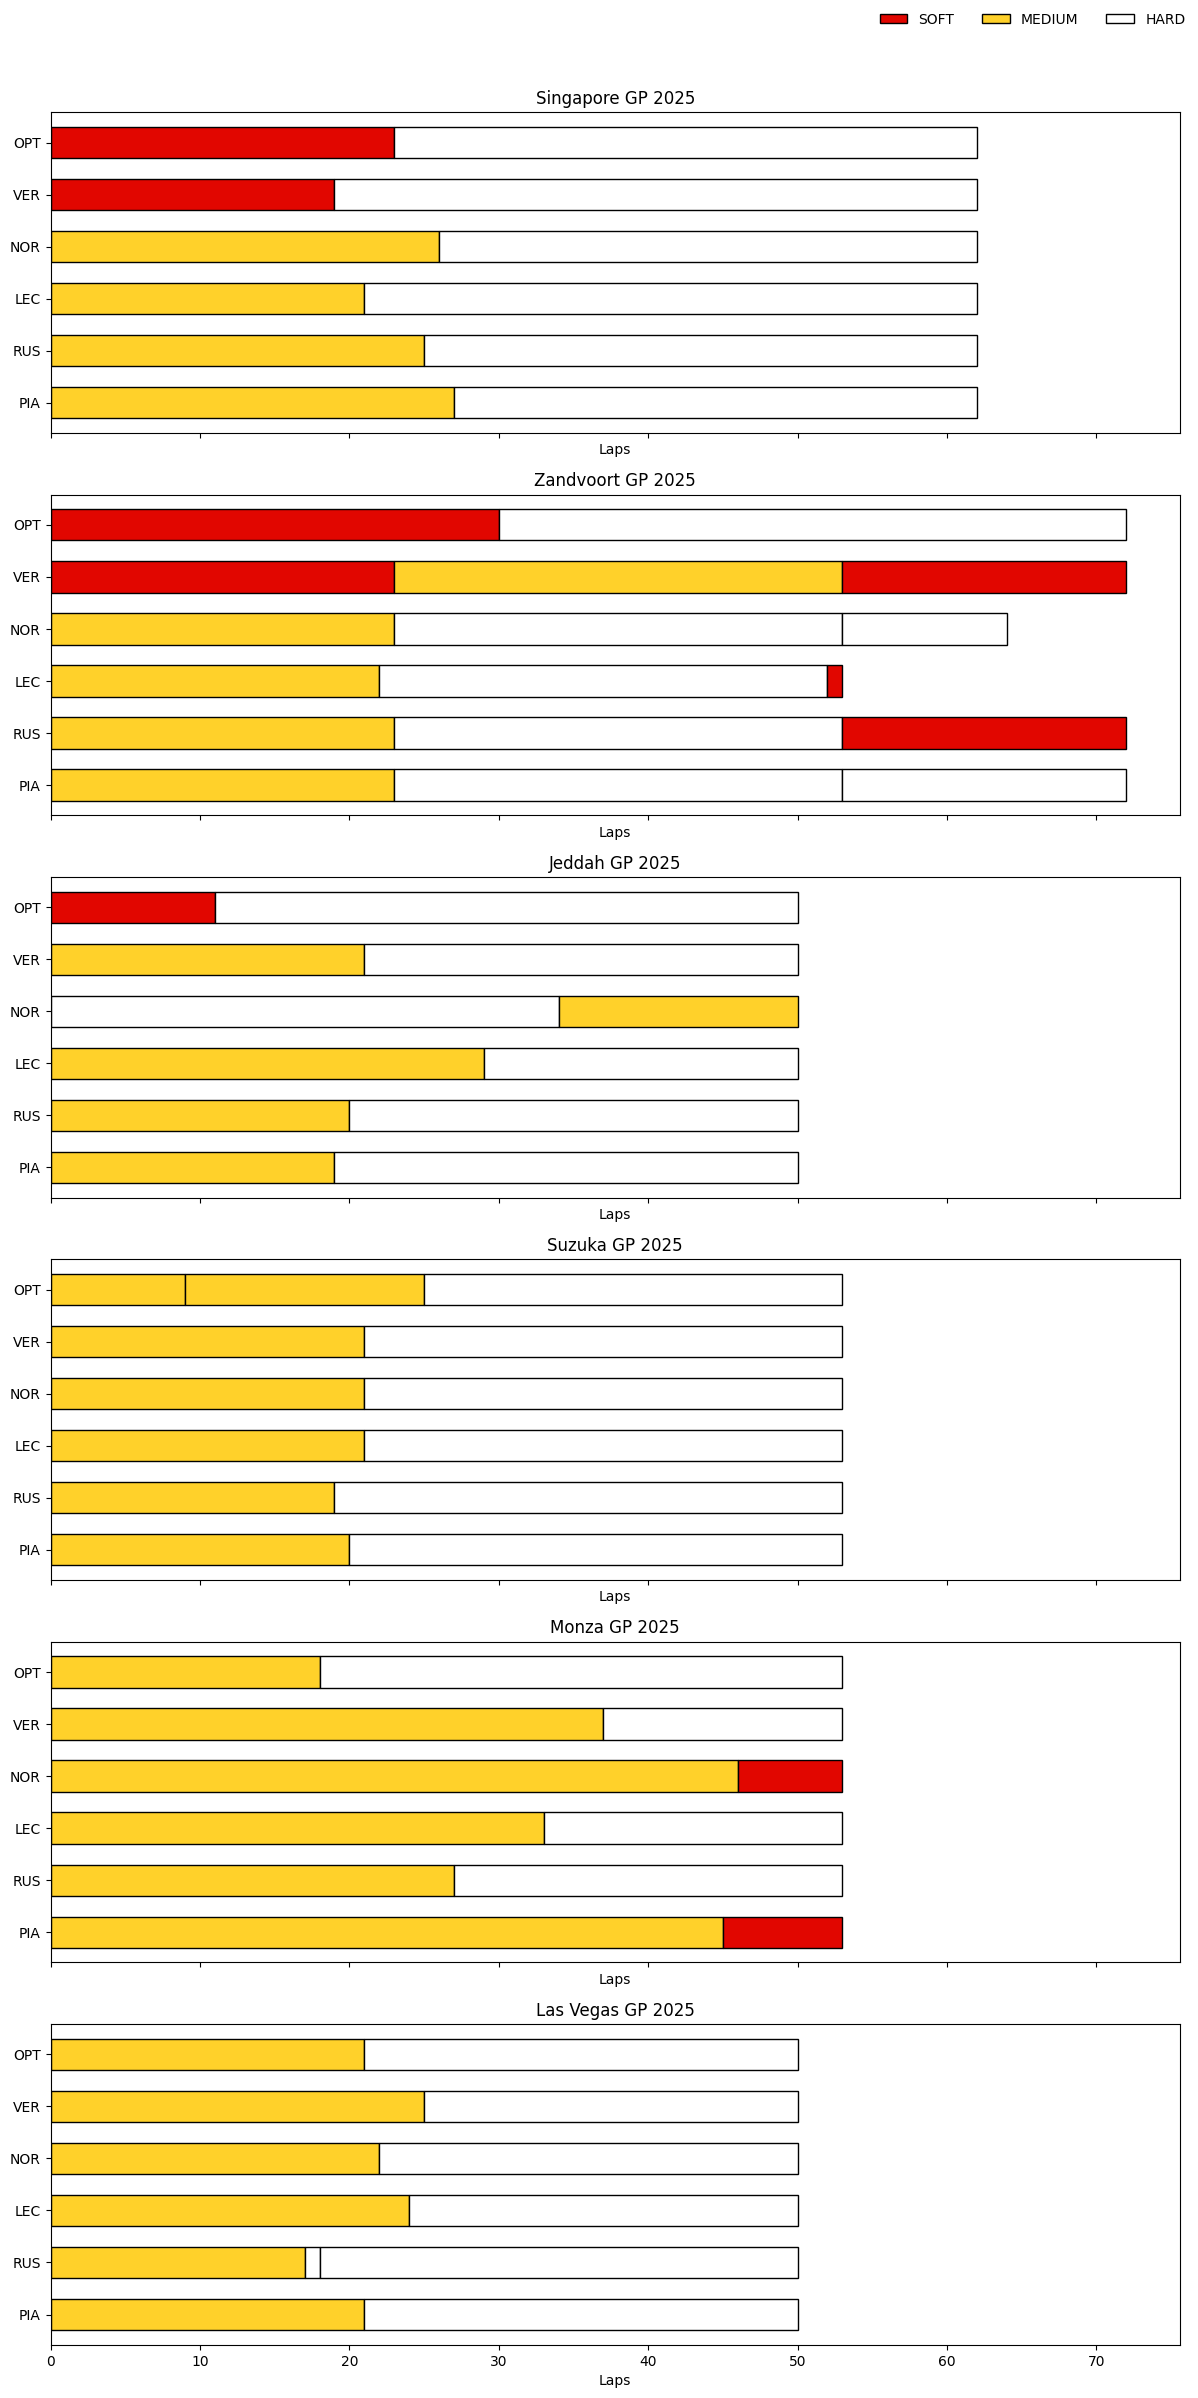

In [10]:
# Creating comparison plot
fig, axes = plt.subplots(
    nrows=len(races),
    ncols=1,
    figsize=(12, 4 * len(races)),
    sharex=True
)

for idx, race in enumerate(races):
    optimizer = F1StrategyOptimizer(
        track=race[0],
        race_laps=race[1],
        pit_stop_overhead=race[2],
        available_tyres=[
            tyre_tuple("SOFT_0", "SOFT", 2),
            tyre_tuple("SOFT_1", "SOFT", 3),
            tyre_tuple("SOFT_2", "SOFT", 0),
            tyre_tuple("MED_0", "MEDIUM", 7),
            tyre_tuple("MED_1", "MEDIUM", 0),
            tyre_tuple("HARD_0", "HARD", 0),
        ],
        models_path="../models"
    )

    model = optimizer.build_model()

    solver = pyo.SolverFactory("glpk")
    results = solver.solve(model, tee=False)

    df = create_stint_df(2025, optimizer, model)
    df = df[df["driver_number"].isin([0] + drivers)].copy()
    driver_strategies = build_driver_strategies(df)

    plot_driver_strategies_ax(
        ax=axes[idx],
        strategies=driver_strategies,
        title=f"{race[0]} GP 2025"
    )

legend_handles = [
    Rectangle((0, 0), 1, 1, color="#e10600", ec="black", label="SOFT"),
    Rectangle((0, 0), 1, 1, color="#ffd12a", ec="black", label="MEDIUM"),
    Rectangle((0, 0), 1, 1, color="#ffffff", ec="black", label="HARD"),
]

fig.legend(
    handles=legend_handles,
    loc="upper right",
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

warnings.filterwarnings('ignore')

In [19]:
track_list = []
pit_time_list = []
stint_data_list = []

for idx, race in enumerate(races):
    optimizer = F1StrategyOptimizer(
        track=race[0],
        race_laps=race[1],
        pit_stop_overhead=race[2],
        available_tyres=[
            tyre_tuple("SOFT_0", "SOFT", 2),
            tyre_tuple("SOFT_1", "SOFT", 3),
            tyre_tuple("SOFT_2", "SOFT", 0),
            tyre_tuple("MED_0", "MEDIUM", 7),
            tyre_tuple("MED_1", "MEDIUM", 0),
            tyre_tuple("HARD_0", "HARD", 0),
        ],
        models_path="../models"
    )

    model = optimizer.build_model()

    solver = pyo.SolverFactory("glpk")
    results = solver.solve(model, tee=False)

    stint_rows = optimizer.extract_solution(model)
    track_list.append(optimizer.track)
    pit_time_list.append(optimizer.pit_stop_overhead)
    stint_data_list.append(stint_rows)

stint_data_df = pd.DataFrame(stint_data_list)
stint_data_df["track"] = track_list
stint_data_df["pit_time"] = pit_time_list

cols = stint_data_df.columns.tolist()
cols = cols[-2:] + cols[:-2]

stint_data_df = stint_data_df[cols]

warnings.filterwarnings('ignore')

In [20]:
stint_data_df = stint_data_df.fillna(0)
stint_data_df

,track,pit_time,0,1,2
0,Singapore,29.1,"{'tyre_id': 'SOFT_0', 'stint_number': 1, 'driv...","{'tyre_id': 'HARD_0', 'stint_number': 2, 'driv...",0
1,Zandvoort,18.5,"{'tyre_id': 'SOFT_1', 'stint_number': 1, 'driv...","{'tyre_id': 'HARD_0', 'stint_number': 2, 'driv...",0
2,Jeddah,17.0,"{'tyre_id': 'SOFT_1', 'stint_number': 1, 'driv...","{'tyre_id': 'HARD_0', 'stint_number': 2, 'driv...",0
3,Suzuka,22.0,"{'tyre_id': 'MED_0', 'stint_number': 1, 'drive...","{'tyre_id': 'MED_1', 'stint_number': 2, 'drive...","{'tyre_id': 'HARD_0', 'stint_number': 3, 'driv..."
4,Monza,25.0,"{'tyre_id': 'MED_0', 'stint_number': 1, 'drive...","{'tyre_id': 'HARD_0', 'stint_number': 2, 'driv...",0
5,Las Vegas,21.0,"{'tyre_id': 'MED_1', 'stint_number': 1, 'drive...","{'tyre_id': 'HARD_0', 'stint_number': 2, 'driv...",0


In [13]:
stint_data_df.iloc[0][0]

{'tyre_id': 'SOFT_0',
 'stint_number': 1,
 'driver_number': 0,
 'lap_start': 1,
 'lap_end': 23,
 'compound': 'SOFT',
 'tyre_age_at_start': 2,
 'stint_time': 2271.788408389414}

In [14]:
len(stint_data_df)

6

In [24]:
results = []

for i in range(len(stint_data_df)):
    compound_laps = {"SOFT": 0, "MEDIUM": 0, "HARD": 0}
    row = stint_data_df.iloc[i]
    track_name = row["track"]


    for j in range(len(stint_data_df.columns) - 2):
        stint = stint_data_df.iloc[i, j + 2]

        if stint == 0 or stint is None:
            continue
        
        compound = stint["compound"]
        laps = stint["lap_end"] - stint["lap_start"] + 1

        compound_laps[compound] += laps

    total_laps = sum(compound_laps.values())

    if total_laps == 0:
        continue

    results.append({
        "Track": track_name,
        "Soft (%)": f"{round(100 * compound_laps['SOFT'] / total_laps, 1)} ({compound_laps['SOFT']} Laps)",
        "Medium (%)": f"{round(100 * compound_laps['MEDIUM'] / total_laps, 1)} ({compound_laps['MEDIUM']} Laps)",
        "Hard (%)": f"{round(100 * compound_laps['HARD'] / total_laps, 1)} ({compound_laps['HARD']} Laps)",
        "Total Laps": total_laps
    })


In [16]:

summary_df = pd.DataFrame(results)
print("Tyre Usage from Model")
print(summary_df)

Tyre Usage from Model
       Track        Soft (%)      Medium (%)        Hard (%)  Total Laps
0  Singapore  37.1 (23 Laps)    0.0 (0 Laps)  62.9 (39 Laps)          62
1  Zandvoort  41.7 (30 Laps)    0.0 (0 Laps)  58.3 (42 Laps)          72
2     Jeddah  22.0 (11 Laps)    0.0 (0 Laps)  78.0 (39 Laps)          50
3     Suzuka    0.0 (0 Laps)  47.2 (25 Laps)  52.8 (28 Laps)          53
4      Monza    0.0 (0 Laps)  34.0 (18 Laps)  66.0 (35 Laps)          53
5  Las Vegas    0.0 (0 Laps)  42.0 (21 Laps)  58.0 (29 Laps)          50


In [31]:
max_tyre_results = []

for i in range(len(stint_data_df)):
    compound_laps = {"SOFT": 0, "MEDIUM": 0, "HARD": 0}
    row = stint_data_df.iloc[i]
    track_name = row["track"]

    for j in range(len(stint_data_df.columns) - 2):
        stint = stint_data_df.iloc[i, j + 2]

        if stint == 0 or stint is None:
            continue

        compound = stint["compound"]
        laps = optimizer.max_age_map[(track_name, compound)]

        compound_laps[compound] += laps

    if total_laps == 0:
        continue

    max_tyre_results.append({
        "Track": track_name,
        "Soft": f"{compound_laps['SOFT']} Laps",
        "Medium": f"{compound_laps['MEDIUM']} Laps",
        "Hard": f"{compound_laps['HARD']} Laps"
    })


In [32]:

tyre_summary_df = pd.DataFrame(max_tyre_results)
print("Max Tyre Life")
print(tyre_summary_df)

Max Tyre Life
       Track     Soft   Medium     Hard
0  Singapore  25 Laps   0 Laps  39 Laps
1  Zandvoort  33 Laps   0 Laps  42 Laps
2     Jeddah  14 Laps   0 Laps  39 Laps
3     Suzuka   0 Laps  44 Laps  28 Laps
4      Monza   0 Laps  30 Laps  35 Laps
5  Las Vegas   0 Laps  21 Laps  29 Laps


In [46]:
results = []

for i in range(len(stint_data_df)):
    total_stint_time = 0
    stint_count = 0

    row = stint_data_df.iloc[i]
    track_name = row["track"]

    for j in range(len(stint_data_df.columns) - 2):
        stint = stint_data_df.iloc[i, j + 2]

        if stint == 0 or stint is None:
            continue

        total_stint_time += stint["stint_time"]
        stint_count += 1

    total_pit_time = row["pit_time"] * (stint_count - 1)

    results.append({
        "Track": track_name,
        "Total Stint Time (s)": total_stint_time,
        "Pit Stops": stint_count - 1,
        "Total Pit Time (s)": total_pit_time,
        "Pit Time (%)": total_pit_time / (total_stint_time + total_pit_time)
    })

In [47]:
stint_pit_ratio_df = pd.DataFrame(results)
print("Stint to Pit Ratio")
print(stint_pit_ratio_df.to_string())

Stint to Pit Ratio
       Track  Total Stint Time (s)  Pit Stops  Total Pit Time (s)  Pit Time (%)
0  Singapore           6129.014256          1                29.1      0.004725
1  Zandvoort           5505.353729          1                18.5      0.003349
2     Jeddah           4727.878896          1                17.0      0.003583
3     Suzuka           5123.088028          2                44.0      0.008515
4      Monza           4520.329838          1                25.0      0.005500
5  Las Vegas           4934.726941          1                21.0      0.004238
